In [1]:
%load_ext autoreload
%autoreload 2
import geopandas as gpd
import multiseg as ms
import pandas as pd
import numpy as np
%matplotlib inline 
from IPython.display import display, Markdown
import glob
import matplotlib.pyplot as plt

## problem with projection
import os
os.environ["PROJ_LIB"] = r"C:\Users\malvarez\AppData\Local\Continuum\miniconda3\envs\py36\Library\share"

## Configure script

Configures:
* street network type, to be used in osmnx
* geographical data projections
* input data folder 
* output folder

In [2]:
retain_all = False                       #retain all only largest connected component
crs_utm = {'init':'epsg:32717'}          #crs that for the city of Cuenca in UTM
input_folder = 'data'              #the input urban areas shapefiles folder

urban_area = 'Sectores_EC.shp'
blocks = 'blocks.shp'                    #the input shapefile name for block geometry
busLine = 'bus_lines.shp'                #the input shapefile name for bus lines
busStop = 'bus_stops.shp'                    #the input file for all bus stop shaspes
tramLine = 'tram_lines.shp'              #the input shapefile name for tram lines
tramStop = 'tram_stops.shp'              #the input shapefile name for tram stops
icvIndex = 'blockICV.csv'    #the input csv for calculated ICV index

graphs_folder = 'output_data/graphs'     #output folder to save graphs
output_path = 'output_data'              #output folder to save the stats
output_img = 'output_data/img'           #output folder to save figures

## Read data 

In [3]:
#import shapefile as geopandas dataframe
blocksGPD =  gpd.read_file('{}/{}'.format(input_folder, blocks))
busLineGPD = gpd.read_file('{}/{}'.format(input_folder, busLine))
busStopGPD = gpd.read_file('{}/{}'.format(input_folder, busStop))
tramLineGPD = gpd.read_file('{}/{}'.format(input_folder, tramLine))
tramStopGPD = gpd.read_file('{}/{}'.format(input_folder, tramStop))


#import ICV index as pandas dataframe
icvIndexDf = pd.read_csv('{}/{}'.format(input_folder, icvIndex), dtype = {
    'id_man': str,
    'Q1' : np.float64, 
    'Q2' : np.float64,
    'Q3' : np.float64,
    'Q4' : np.float64,
    'ICV': np.float64,
    'nDwelling' : np.int32, 
    'nPeople' : np.int32    
})

In [4]:
display(
    Markdown('**General Information**'),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: ' + str(len(blocksGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: ' + str(len(icvIndexDf))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: ' + str(len(busLineGPD.LINEA.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: ' + str(len(busStopGPD.index))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: ' + str(len(tramLineGPD.FID_.unique()))),
    Markdown('&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: ' + str(len(tramStopGPD.index)))
)

**General Information**

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks: 3800

&nbsp;&nbsp;&nbsp;&nbsp;Number of Blocks with ICV: 3391

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Lines: 29

&nbsp;&nbsp;&nbsp;&nbsp;Number of Bus Stops: 3037

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram Lines: 1

&nbsp;&nbsp;&nbsp;&nbsp;Number of Tram stops: 41

## Create boundary from block geometries

Blocks define the urban area that will be used in the analysis. 
An $\alpha$ -shape with $\alpha =0.0025$ is used to create a polygon that define the boundary around multiple unconnected block geometries.

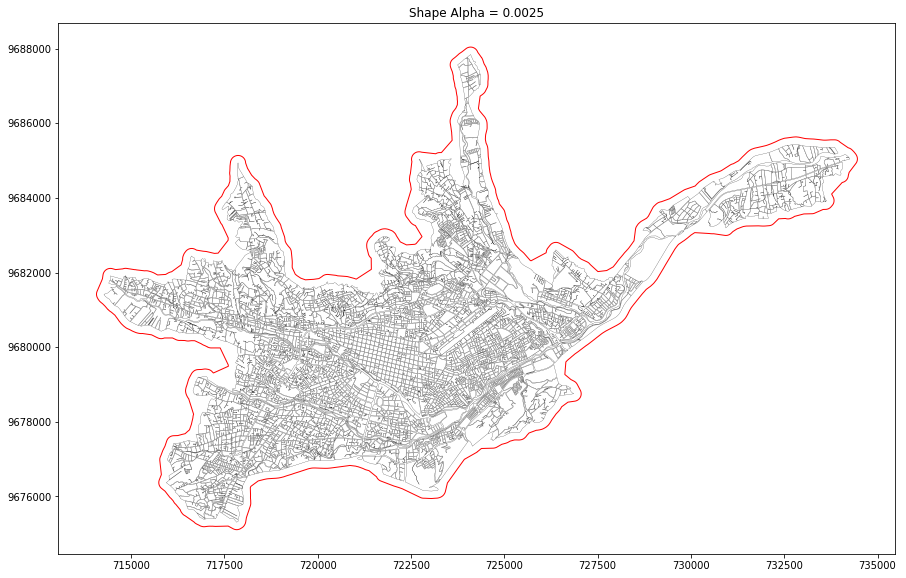

In [5]:
alpha = 0.0025
boundary = ms.boundary_from_areas(blocksGPD, alpha = alpha, buffer_dist=200)
base = blocksGPD.plot(color = 'white',edgecolor='black',linewidth=0.2,  figsize = (15,10))
base.set_title("Shape Alpha = {}".format(alpha))
boundary.plot(color = "None", edgecolor='red',linewidth=1, ax = base)
plt.show()

In [6]:
# turn polygon to geopandas data frame with projection
boundaryGPD = gpd.GeoDataFrame(geometry = boundary)
boundaryGPD.crs = crs_utm

## Create street network

Creates a time weighted graph that represents the street network with an average walking speed = 5Km/h.

* data source: OpenStreetMap, using OSMnx

In [7]:
street_network = ms.street_graph_from_boundary(boundaryGPD)

Generating street graph using OSMnx
created street network graph


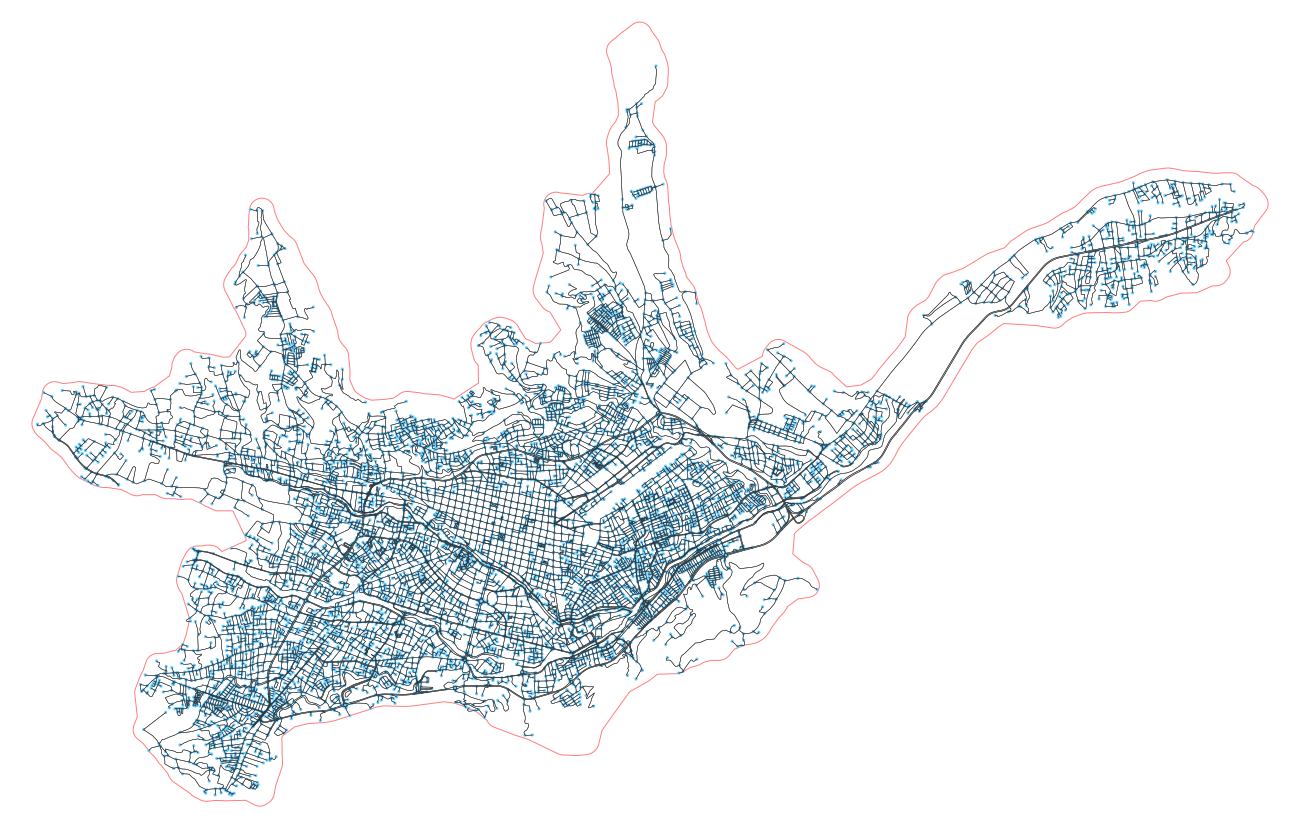

In [8]:
ms.plot_network(street_network, boundary)

## Create bus network

Creates a time weighted graph that represents the bus network with an average speed of = 30Km/h.

* data source: Municipality of Cuenca, Ecuador.

In [9]:
# creates bus network from lines and stops shape file
bus_network = ms.transport_graph_from_lines_stops(busLineGPD, 
                                                  busStopGPD, 
                                                  boundaryGPD, 
                                                  speed = 30,
                                                  group_lines_by = "LINEA",
                                                  group_stops_by = "lineNum",
                                                  lines_data = {"LINEA": "line", "RUTA":"route"},
                                                  stops_data = {'C2': 'name', 'N_líneas': 'number_of_lines'})

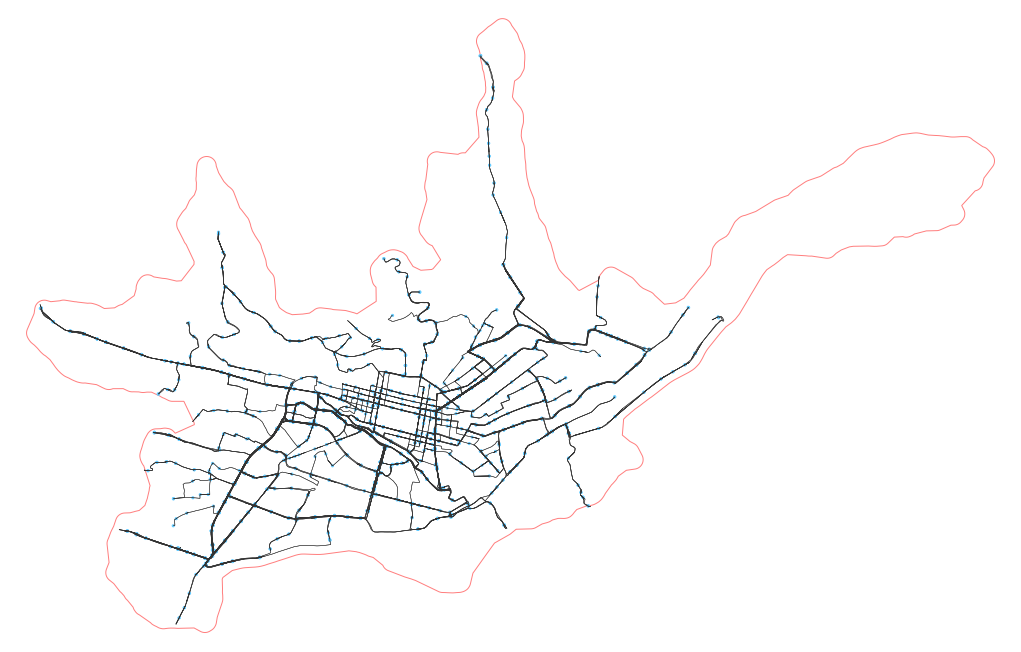

In [10]:
ms.plot_network(bus_network, boundary)

## Create tram network

Creates a time weighted graph that represents the tram network with an average speed of = 30Km/h.

* data source: Municipality of Cuenca, Ecuador.

In [11]:
# creates bus network from lines and stops shape file
tram_network = ms.transport_graph_from_lines_stops(tramLineGPD, 
                                                  tramStopGPD, 
                                                  boundaryGPD, 
                                                  speed = 40,
                                                  lines_data = {"Layer": "line"})

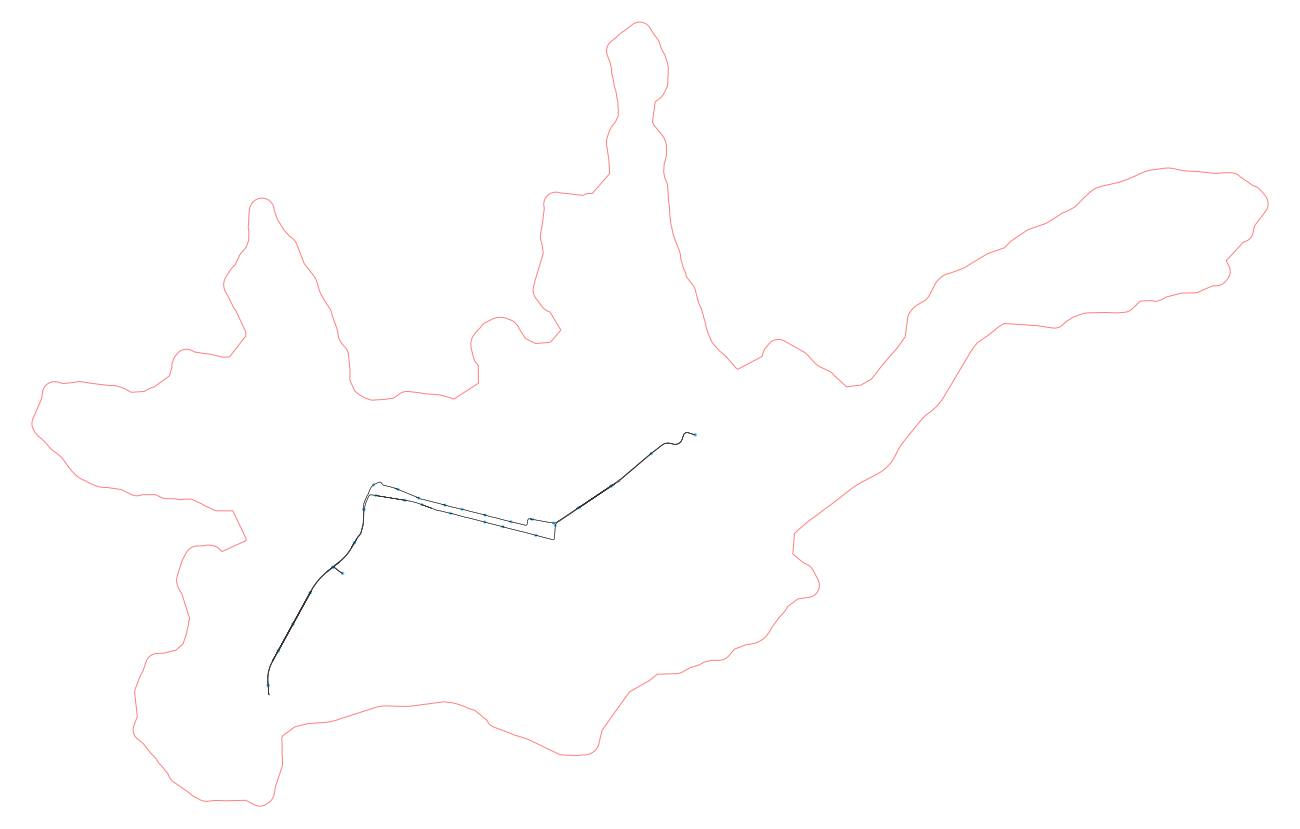

In [12]:
ms.plot_network(tram_network, boundary)

## Assign Socio Economic Data to Nodes

Voronoi tesselation and weighted area overlay interpolation are used to determine population data at each node of the road network.

In [13]:
#join ICV dataframe to block geometry
blocksICV = blocksGPD.merge(icvIndexDf, left_on = 'DPA_MANZAN', right_on = 'id_man')

#only conserve valid geometries with values
blocksICV = blocksICV[blocksICV.is_valid]
blocksICV = blocksICV.dropna()

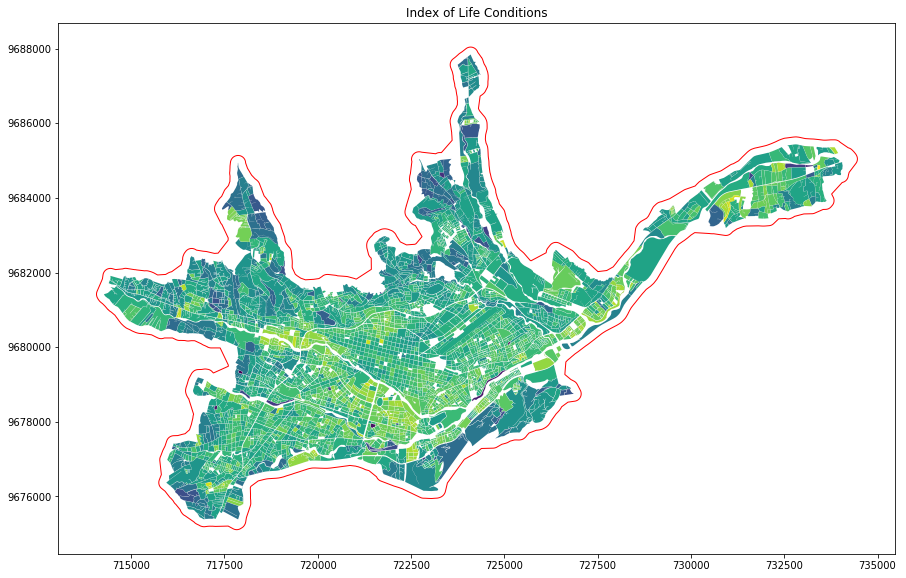

In [14]:
# plot initial data
base = blocksICV.plot(column = "ICV", edgecolor='black', cmap='viridis', linewidth=0.01,  figsize = (15,10))
base.set_title("Index of Life Conditions")
boundary.plot(color = "None", edgecolor='red',linewidth=1, ax = base)
plt.show()

In [ ]:
# map data to intersection
street_network = ms.blocks_to_nodes(street_network, 
                                   blocksICV, 
                                   area, 
                                   crs_utm)

In [15]:
tessellation = ms.create_node_voronoi(street_network, boundaryGPD)

In [ ]:
temp = ms.area_overlay(blocksICV, tessellation, 'nPeople', ['ICV'], ['Q1', 'Q2', 'Q3', 'Q4'])

In [ ]:
# plot initial data
base = temp.plot(column = "ICV", edgecolor='black', cmap='viridis', linewidth=0.01,  figsize = (15,10))
base.set_title("Index of Life Conditions")
boundary.plot(color = "None", edgecolor='red',linewidth=1, ax = base)
plt.show()

In [ ]:
target_geom = polygonsGPD.iloc[[1]].geometry[1]
sindex = blocksICV.sindex
matches_index = list(sindex.intersection(target_geom.bounds))

In [ ]:
from geopandas.tools import overlay
intersection = overlay(blocksICV.iloc[[matches_index[0]]],
                      polygonsGPD.iloc[[1]], 
                      how = 'intersection')

In [ ]:
blocksICV.iloc[[matches_index[0]]]['nPeople'].values[0]

In [ ]:
intersection.area

In [ ]:
from multiseg import *
tolerance = 20
for group in lines.grouped.unique():
    lines_subset = lines[lines.grouped == group]

    # loop through individual geometries
    for i, row in lines_subset.iterrows():
        print(group, i)
        geom = row.geometry

        # check if line is MultiLineString
        if isinstance(geom, geometry.MultiLineString):
            geom_list = geom.geoms

            # create empty list to store coordinates of line
            lines_coords = []
            for line in geom_list:
                # if line is not smaller than tolerance meters and not a self-loop
                if line.length > tolerance and line.coords[0] != line.coords[-1]:
                    coord_list = list(line.coords)
                    lines_coords.append(coord_list)

            # choose first line and look for continuation
            line_coord = lines_coords[0]
            line_list = lines_coords[1:]

            line_joined = join_lines(line_coord, line_list)
            line_joined = join_lines(list(reversed(line_joined)), line_list)

            line_geom = geometry.LineString(coor for coor in line_joined)

        else:
            line_geom = geom

        lines_list.append(line_geom)

In [ ]:
if isinstance(geom, geometry.MultiLineString):
    geom_list = geom.geoms

    # create empty list to store coordinates of line
    lines_coords = []
    for line in geom_list:
        # if line is not smaller than tolerance meters and not a self-loop
        if line.length > tolerance and line.coords[0] != line.coords[-1]:
            coord_list = list(line.coords)
            lines_coords.append(coord_list)

    # choose first line and look for continuation
    line_coord = lines_coords[0]
    line_list = lines_coords[1:]

    line_joined = join_lines(line_coord, line_list)
    line_joined = join_lines(list(reversed(line_joined)), line_list)

    line_geom = geometry.LineString(coor for coor in line_joined)

In [ ]:
line_joined = join_lines(list(reversed(line_joined)), line_list)

In [ ]:
line_list

In [ ]:
geom_list = geom.geoms

In [ ]:
for line in geom_list:
    # if line is not smaller than tolerance meters and not a self-loop
    if line.length > 20 and line.coords[0] != line.coords[-1]:
        coord_list = list(line.coords)
        lines_coords.append(coord_list)

# choose first line and look for continuation
line_coord = lines_coords[0]
line_list = lines_coords[1:]

In [ ]:
line_joined = ms.join_lines(line_coord, line_list)

In [ ]:
line_joined = ms.join_lines(list(reversed(line_joined)), line_list)

In [ ]:
line_geom = ms.geometry.LineString(coor for coor in line_joined)

In [ ]:
line_geom

In [ ]:
geom

In [ ]:
line = bus_lines.geometry[3]
isinstance(line, ms.geometry.MultiLineString)
lgeos = line.geoms

lines = []
for tl in lgeos:
    tlines = []
    if tl.length > 20 and tl.coords[0] != tl.coords[-1]:
        coord = list(tl.coords)
        lines.append(coord)

In [ ]:
list_= [1,2,3,4]
list_
    

In [ ]:
list_.remove(3)
list_

In [ ]:
lines_list = []
for lineNum in busLineGPD.LINEA.unique():
    bus_lines = busLineGPD[busLineGPD.LINEA == lineNum]
    for i, bus_line in bus_lines.iterrows():
        line = bus_line.geometry
        #check if line is multilinestring to store as multiple singlelinesstrings
        if isinstance(line, ms.geometry.MultiLineString):
            print(lineNum, i)
            break
            lgeos = line.geoms
            lines = []
            for tl in lgeos:
                tlines = []
                if tl.length > 20 and tl.coords[0] != tl.coords[-1]:
                    coord = list(tl.coords)
                    for j in range(len(coord)):
                        point = coord[j]
                        tlines.append(point)
                    lines.append(coord)
            #choose first line and look for continuation
            lineCoord = lines[0]
            lineList = lines[1:]
            lineJoin = join_lines(lineCoord, lineList)
            lineJoin = join_lines(list(reversed(lineJoin)), lineList)
            tlines = geometry.LineString(coor for coor in lineJoin)
            linesGPD = gpd.GeoDataFrame({'nline': [bus_line.LINEA],
                                         'way': [bus_line.TRAYECTO],
                                         'route': [bus_line.RUTA],
                                         'geometry': [tlines],
                                         'ngeom': [1],
                                       })
        else:
            linesGPD = gpd.GeoDataFrame({'nline': [bus_line.LINEA],
                                         'way': [bus_line.TRAYECTO],
                                         'route': [bus_line.RUTA],
                                         'geometry': [line],
                                         'ngeom': [1]
                                       })

        lines_list.append(linesGPD)
res = gpd.GeoDataFrame(pd.concat(lines_list, ignore_index=True))
return res

In [ ]:
busStopGPD.to_file("bus_stops.shp")